<a href="https://colab.research.google.com/github/sabinnmc/machine_learning_By_Recursive/blob/main/Homework_Assignment_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Recursive technical homework

## Motivation
We hope you have fun doing this task as well as learn something new.

Do not be discouraged if you find the task challenging. Feel free to research as much as you want on Google or any other resource to solve this task. You are welcome to copy code snippets from stackoverflow, tutorials, blog posts, etc to help you finish the task. Make sure you understand them though :)

The goal is to push yourself a little and see how you like solving new problems using scientific computing and data analysis.

**About colab**

Please create a duplicate of this notebook using File > Save a Copy in Drive. Share your solution via a link to your local copy of the notebook.

You can solve the entirety of this task using a free kernel running in the cloud. Just click 'Connect' on the top right of the notebook. You can use any python libraries you want *unless* explicitly told to code your own algorithm. If a library you want to use is not already available from the colab runtime, go to 'Help' > 'Search code snippets' > Type 'Importing a library that is not in Colab' to learn how to install a library using pip.


# Thank you Recursive team for this challenge

# Part 1
Understanding Stochastic Gradient Descent.
In this exercise, we want to implement [Stochastic Gradient descent](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) without using a built-in optimizer, to understand how parameters are optimized at the low level.

Let's consider a toy problem of [Logistic Regression](https://en.wikipedia.org/wiki/Logistic_regression). The data generation process is such that we have one floating point variable $x \in [0,1]$, and one categorical variable $y\in \{0,1\}$. The Logistic Regression problem is to find the optimal parameters for the logistic function to predict the probability of $y$ given $x$.

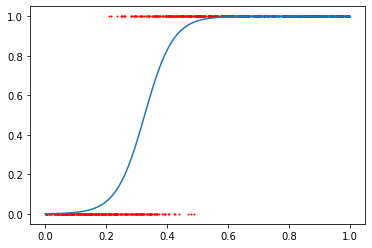

In the image above, the x and y axis correspond to the variables defined previously, with the red "dots" the true data as generated by the process defined below, and the blue line is the optimal logistic decision function learned from the data.

The optimal parameters can be found numerically using gradient descent. In this case, we will be using SGD (batched gradient descent) to optimize the two parameters in the logistic function, $\beta_1, \beta_2$.

If ${p(x)={\frac {1}{1+e^{-(\beta _{1}+\beta _{2}x)}}}}$, then we want to find $\beta_1, \beta_2$ such that the [negative log likelihood](https://en.wikipedia.org/wiki/Likelihood_function) is minimized. In this case, ${\ell =\sum _{k=1}^{K}\left(\,y_{k}\ln(p_{k})+(1-y_{k})\ln(1-p_{k})\right)}$, and the SGD formula is simply:
$\beta_i = \beta_{i-1} - \alpha * \nabla \ell$.

The data generation process as well as the pseudo-code is provided for you below, your task is to fill in the appropriate pytorch code. *Do not use the built-in optimizer*, implement SGD using tensor operations alone.


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
def generate_data():
  data = torch.rand(1000, 2)                               # random data between 0 1nd 1 , 1000*2 matrix
  label = ((data[:,0]+0.3*data[:,1]) > 0.5).to(torch.int)  # true case = 1 and false case = 0
  return data[:,0], label                                  # return first features of data and above label value

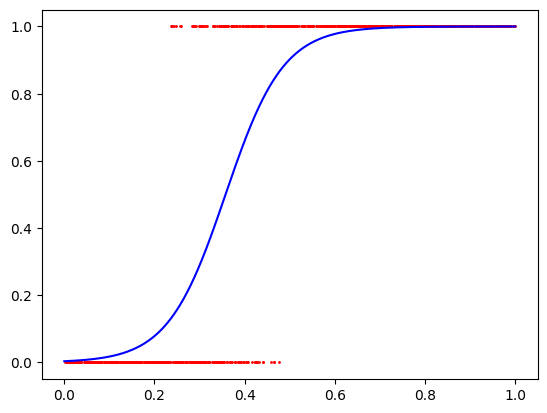

In [ ]:
input, label = generate_data()

# Make minibatches.
inputs = torch.split(input, 32)        # 1000 data is divided  batch where data are in one batch
labels = torch.split(label, 32)

# Define the two variables to optimize
b1 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)
b2 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)

# setting a hyperparameter to adjust parameter during each step of optimixzation process
learning_rate = 0.1
for epoch in range(15):
  for x, y in zip(inputs,labels):
    # Calculate p_x as per formula above
    p_x = 1/ (1 + torch.exp(-(b1 + b2 * x)))
    # Calculate the negative loss likelihood
    l = -torch.sum(y * torch.log(p_x) + (1 - y) * torch.log(1 - p_x))
    # Calculate the gradient of the loss w.r.t. the inputs
    l.backward()
    # Update the parameters b according to SGD formula
    with torch.no_grad():
      b1 -=  learning_rate *b1.grad
      b2 -=  learning_rate *b2.grad

    # Clear the gradients
    b1.grad.zero_()
    b2.grad.zero_()

    # Print out the loss value
    l += l.item()
    #print(f" Epoch: {epoch + 1},   loss value: {l} ")
# Reproduce the image above to validate your result.

# creating a point for curve as mention above
x_axis = torch.linspace(0, 1, 1000)
y_axis = 1 /(1+ torch.exp(-(b1.item() + b2.item() * x_axis)))  # using a learn parameter b1(beta 1) and b2(beta 2)

# scatter plot of above data points
plt.scatter(input[label == 1], label[label == 1], color = 'red', label = 'Upper limit', s = 1)
plt.scatter(input[label == 0], label[label == 0], color = 'red', label = 'Lower limit', s = 1)

# ploting a boundary
plt.plot(x_axis, y_axis, color ='blue', label ="Optimal decision boundary")
#plt.legend()
plt.show()

# Part 2-1

Researchers have measured a bivariate timeseries, but the equipment was unreliable so the data has gaps as well as noise. The data can be found in [data.csv](https://gist.github.com/tmramalho/51733432c88e2b834dbd70353849f887)

In this exercise, we want to train an [MLP](https://en.wikipedia.org/wiki/Multilayer_perceptron) to regress the full observed trajectory from the measured data. Formally, the MLP will be used to approximate the function $f:\mathbb{R} \rightarrow \mathbb{R}^2 ; f(t) = (x(t), y(t))$. In other words, the model takes the current time as an input, and predicts the values of `x` and `y` at that time based only on the measured data.

Your task is to define the data loader, the MLP model and the loss function to complete this task successfully. For this problem you will need to use a regression loss, not a classification loss.

Successful training should result in a data interpolation similar to the below:
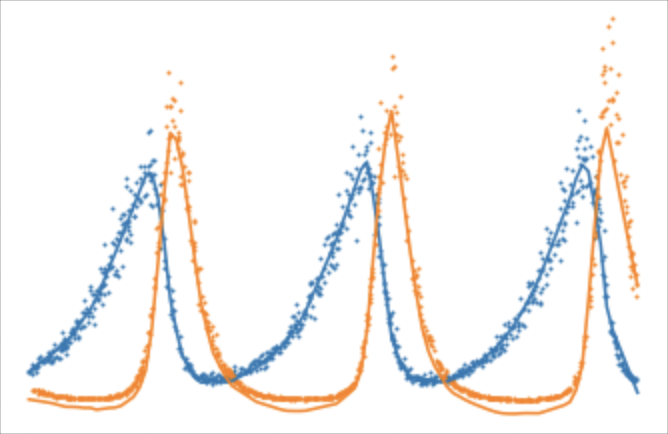

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Net(nn.Module):
    '''Model to regress 2d time series values given scalar input.'''
    def __init__(self):
        super(Net, self).__init__()
        #TODO
        self.func1 = nn.Linear(1, 64)     # input feature -> 1 i.e. time, 32 neurons
        self.func2 = nn.Linear(64, 64)    # hidden layer
        self.func3 = nn.Linear(64, 2)     # output layer (x(t), y(t) -> 2 neurons)
        '''  # #  activation function  ##
        1. activation function allow neural network to learn and represent complex,
           linear realtioship in data
        2. ReLU(x) = max(0, x)  -> this result only positive number(x) in output or zero
           in case of zero or negative number
        3. applied in every input layer except utput layer
        '''
        # extra ___________________________________________________________
        # initialize weight properly
        nn.init.xavier_uniform_(self.func1.weight)
        nn.init.xavier_uniform_(self.func2.weight)
        nn.init.xavier_uniform_(self.func3.weight)

        self.activation = nn.ReLU()

    def forward(self, x):
        #TODO
        # data pass : input layer -> hidden layer -> output layer
        # feedforward process where input layer is tranform through successive linear transformation
        x = self.activation(self.func1(x))      #
        x = self.activation(self.func2(x))
        x = self.func3(x)
        return x

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(self, csv_file):
        #TODO
        # loading a time series from a CSV file
        # as csv file contain "- " which act as string need to replace with NaN, then only droping
        self.data = pd.read_csv("/content/sample_data/data.csv").replace("-", np.nan).dropna()

        # using a interploation to fill missing values
        #self.data.interpolate(method='linear', inplace=True)

        # # converting the 'x' and 'y' columns to numeric, forcing non-numeric values to NaN
        self.data['x'] = pd.to_numeric(self.data['x'], errors='coerce')
        self.data['y'] = pd.to_numeric(self.data['y'], errors='coerce')

        # convert to tensor with explicit data type
        # iloc[:, 0]  -> select all row and first column
        # .values -> attribute that convert selected dataframe into numPy array
        # iloc -> integer location based indexing method used in pandas
        self.t = torch.tensor(self.data.iloc[:, 0].values, dtype = torch.float32)
        self.xy = torch.tensor(self.data.iloc[:, 1:3].values, dtype = torch.float32)

    def __len__(self):
        #TODO
        return len(self.t)

    def __getitem__(self, idx):
        #TODO
        return self.t[idx], self.xy[idx]

In [ ]:
# training  a model
# smaller batch size is better for stability other thing compromised too
BATCH_SIZE = 32
dataset = TimeSeriesDataset('/content/sample_data/data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

def loss_fn(outputs, labels):
  #TODO
  # mean square error(MSE) loss is usually preferred in regression problem
  # MSE = [(observerd value- predicted value )^2] / ( number of data point )
  return nn.MSELoss()(outputs, labels)

# define architecture and behaviour of neural network model
# Net()  inherits from torch.nn.Module -> provide access to PyTorch's neural ntw function
net = Net()
#TODO what is a good optimizer?
optimizer = optim.Adam(net.parameters(), lr = 0.001)

# setting model to train
net.train()

Net(
  (func1): Linear(in_features=1, out_features=128, bias=True)
  (func2): Linear(in_features=128, out_features=128, bias=True)
  (func3): Linear(in_features=128, out_features=128, bias=True)
  (func4): Linear(in_features=128, out_features=2, bias=True)
  (activation): Tanh()
)

In [ ]:
for epoch in range(300):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        #outputs = net(inputs)
        outputs = net(inputs.unsqueeze(1))
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        # if i % 32 == 31:    # print every 20 mini-batches
        #     print('[%d, %5d] loss: %.3f' %
        #           (epoch + 1, i + 1, running_loss / 20))
        #     running_loss = 0.0

print('Finished Training')

Finished Training


 firdt 5 predicted values:  [0.33812228 0.33214846 0.3253323  0.31757036 0.3087496 ]


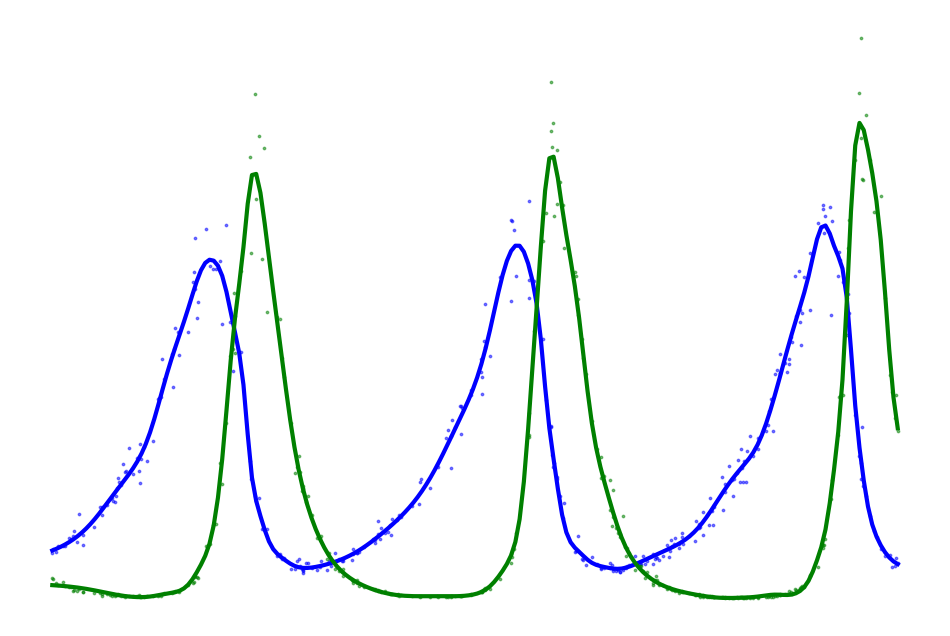

In [ ]:
# Plot results to validate training
# Generate test time points for smooth interpolation
t_test = np.linspace(dataset.t.min().item(), dataset.t.max().item(), 200)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32).reshape(-1, 1)

# Get predictions
net.eval()
with torch.no_grad():
    predicted_xy = net(t_test_tensor).numpy()

# Convert dataset tensors to numpy for plotting
t_actual = dataset.t.numpy()
xy_actual = dataset.xy.numpy()

# Create plot
plt.figure(figsize=(12, 8))
# creating a custom color

# Plot with increased marker size and line width
# Actual data points
plt.scatter(t_actual, xy_actual[:, 0], color='blue', alpha=0.5, label='Actual x', s=3)
plt.scatter(t_actual, xy_actual[:, 1], color='green', alpha=0.5, label='Actual y', s=3)

# Predicted curves - make lines more visible
plt.plot(t_test, predicted_xy[:, 0], 'b-', linewidth=3, label='Predicted x', zorder=10,)
plt.plot(t_test, predicted_xy[:, 1], 'g-', linewidth=3, label='Predicted y', zorder=10)


print(" firdt 5 predicted values: ", predicted_xy[:5, 1])
# removing axes border
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

# removing a marking tick on x and y axes
plt.xticks([])
plt.yticks([])
# plt.draw()
# plt.pause(0.1)
plt.show()

# Part 2-2 Time-series extension

The simplified model above will only work well if $t\in[0,20]$.
Create a different model that can extrapolate `x,y` predictions to $t>20$.
Assume that the model has access to the same data as above, and is tasked to predict up to $t=100$. You can change anything in the above setup as needed, including model architecture, loss function, training procedure or data loader.

There are several different correct approaches to tackle this problem, all with different pros and cons, so make sure to explain your reasoning for the different choices made.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# why nn.Tanh activation is used?
since i tried nn.ReLU , nn.siLU and even try parametric ReLU but graph seem very odd in all but gragh see quit decent in nn.Tanh activation. As it is bad for large prediction and saturate between [-1,1] , but visually this seem quite digestiable. Even though it is not best pratical choice but this model less likely to explode when predicting.

Please forgive if you think this is very bad choice

In [ ]:
# creating a separate  model
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.func1 = nn.Linear(1, 128)
    self.func2 = nn.Linear(128, 128)
    self.func3 = nn.Linear(128, 128)
    self.func4 = nn.Linear(128, 2)

    # use Tanh activation for better exrapolation prevoiusly but very bad for large extrapolation
    self.activation = nn.Tanh()
    # using ReLU
    #self.activation = nn.ReLU()
    # using nn.siLU
    #self.activation = nn.SiLU()
    # # initialize  weights properly for nn.Tanh/nn.siLU/nn.GELU activation
    nn.init.xavier_uniform_(self.func1.weight)
    nn.init.xavier_uniform_(self.func2.weight)
    nn.init.xavier_uniform_(self.func3.weight)
    nn.init.xavier_uniform_(self.func4.weight)

    # # initialize for ReLU
    # nn.init.kaiming_uniform_(self.func1.weight)
    # nn.init.kaiming_uniform_(self.func2.weight)
    # nn.init.kaiming_uniform_(self.func3.weight)
    # nn.init.kaiming_uniform_(self.func4.weight)



  def forward(self, x):
    x = self.activation(self.func1(x))
    x = self.activation(self.func2(x))
    x = self.activation(self.func3(x))
    x = self.func4(x)
    return x

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
  def __init__(self, csv_file):
     super().__init__()

     self.data = pd.read_csv('/content/sample_data/data.csv')
     #converting a "-" inside a CSV file to NaN and drop missing rows
     self.data.replace("-", np.nan, inplace = True)
     self.data.dropna(inplace = True)

     # convert to numeric
     self.data['x'] = pd.to_numeric(self.data['x'])
     self.data['y'] = pd.to_numeric(self.data['y'])

     # Explicitly convert the first column to numeric and handle potential errors
     self.data.iloc[:, 0] = pd.to_numeric(self.data.iloc[:, 0], errors='coerce')  # 'coerce' will replace invalid values with NaN
     self.data.dropna(inplace=True)  # Drop rows with NaN values again after conversion


     # Normalize time for better extrapolation
     self.t_min = self.data.iloc[:, 0].min()
     self.t_max = self.data.iloc[:, 0].max()
     # min-max normalization range 't' value into range of [0, 1]
     # neural network stability work best in range [0, 1] or [-1,1] thefore to achieve thus min-max normalization is done
     # x_normalize = (x - xmin)/ (xmax -xmin)
     self.t = torch.tensor((self.data.iloc[:,0].to_numpy() -self.t_min) / (self.t_max - self.t_min), dtype = torch.float32)
     self.xy = torch.tensor(self.data.iloc[:, 1:3].values, dtype = torch.float32)

  def __len__(self):
    return len(self.t)

  def __getitem__(self, idx):
     return self.t[idx], self.xy[idx], self.t_min, self.t_max

In [ ]:
# training  a model
# smaller batch size is better for stability other thing compromised too
BATCH_SIZE = 32
dataset = TimeSeriesDataset('/content/sample_data/data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

def loss_fn(outputs, labels):
  #TODO
  # mean square error(MSE) loss is usually preferred in regression problem
  # MSE = [(observerd value- predicted value )^2] / ( number of data point )
  return nn.MSELoss()(outputs, labels)

# define architecture and behaviour of neural network model
# Net()  inherits from torch.nn.Module -> provide access to PyTorch's neural ntw function
net = Net()

# setting model to train
net.train()

Net(
  (func1): Linear(in_features=1, out_features=128, bias=True)
  (func2): Linear(in_features=128, out_features=128, bias=True)
  (func3): Linear(in_features=128, out_features=128, bias=True)
  (func4): Linear(in_features=128, out_features=2, bias=True)
  (activation): Tanh()
)

# Adam optimizer
*   Adaptive moment estimation (Adam) adjust lr rates for each parameter dynamically
*   work well mini batch like 32
* adam is faster aand have better convergence than SGD(stochastic Gradient Descent)



In [ ]:
# training adjustments

optimizer = optim.Adam(net.parameters(), lr = 0.001)
# step learning rate scheduler(stepLR)
''' 1.  creating a case for every 100 epoches , lr = lr *0.5(reduce by half)
    2.  to ensure model doesnot memorize data and produce stable for t > 20
    3.  cosineAnnealingLR is best aternative od stepLR  but effective for 1000s of epochs
'''
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size= 100, gamma= 0.5)

# just pumping more epoch for better learning
for epoch in range(500):
  running_loss = 0.0
  for i, data in enumerate(trainloader, 0):
    inputs, labels, t_min, t_max = data

    # reset old gradient before new gradient start
    optimizer.zero_grad()
    # .unsqueeze(1) -> convert (N,1)  -> (N) function add new dimension at index 1
    outputs = net(inputs.unsqueeze(1))
    loss = loss_fn(outputs, labels)
    loss.backward()
    # updating weight
    optimizer.step()

  #  this is learning rate scheduler adjust learning rate  over a time
  scheduler.step()

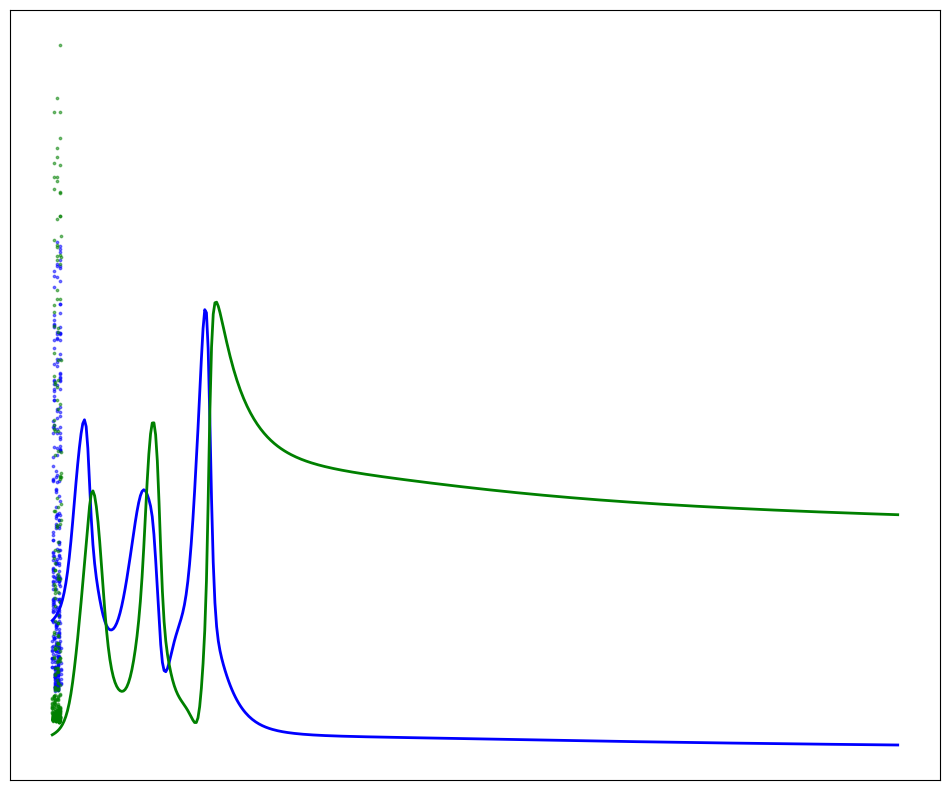

In [ ]:
# increase range of extrapolation
t_test = np.linspace(0, 100, 500)
# accessing t_min and t_max data point in trainloader
_,_,t_min, t_msx = next(iter(trainloader))
t_test_normalized = (t_test - dataset.t_min) / (dataset.t_max - dataset.t_min)
t_test_tensor = torch.tensor(t_test_normalized, dtype = torch.float32).reshape(-1,1)

# starting evaluation
net.eval()
with torch.no_grad():
  predicted_xy = net(t_test_tensor).numpy()

#plot results
plt.figure(figsize=(12,10))
# actual x and y
plt.scatter(dataset.t.numpy(), dataset.xy.numpy()[:, 0], color = "blue", s = 3, alpha=0.5 )
plt.scatter(dataset.t.numpy(), dataset.xy.numpy()[:, 1], color="green", s = 3, alpha=0.5)

# predicted x and y
plt.plot(t_test, predicted_xy[:, 0], "b-", linewidth = 2, zorder = 10, label = " x-predicted")
plt.plot(t_test, predicted_xy[:, 1], "g-", linewidth = 2, zorder = 10, label = "y-predicted")

plt.xticks([])
plt.yticks([])
plt.show()


# Part 3-1a

Please implement the below function `min_dist`. This function should take a sparse list of 2D coordinates, and map them to a 2D tensor of a specified resolution. The values of each pixel in the tensor should correspond to the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between that pixel and the closest pixel which contains a data point.

You can use either numpy or pytorch tensor operations to implement the function. Use only tensor operations, no for-loops are necessary.

Here are the example outputs for the two test cases highlighted below:

Case 1: data at `[0.4, 0.3], [0.6, 0.7]`, resolution 20 pixels.

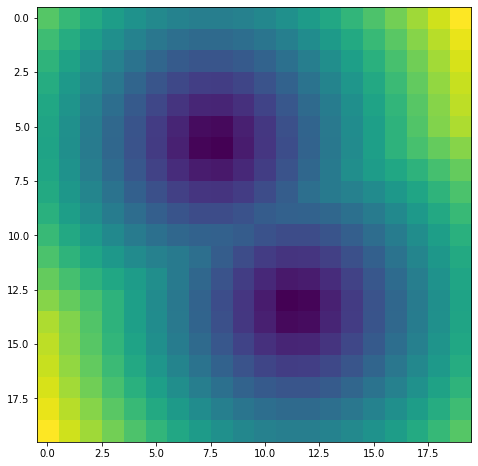


Case 2: data at `[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]`, resolution 256 pixels.

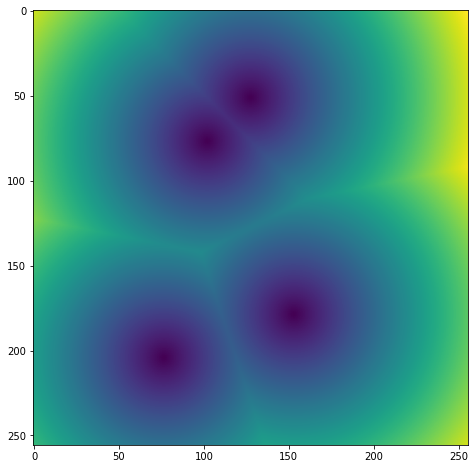


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt


In [ ]:
def min_dist(points, res):
  """Calculates a 2D tensor with the minimum distance from each pixel to data.

  Inputs:
    * points: a python list of 2D coordinates, normalized in the range [0,1]
    * res: the resolution of the output tensor.
  Returns:
    A res x res square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points.
  """
  # step 1 : create a 2D tensor with normalize coordinates [0,1] range
  # here 'res' number is generated in range of 0 to 1 for x, and y
  x = torch.linspace(0, 1, res)
  y = torch.linspace(0, 1, res)
  # creating a matrix of res * res for both x, y

  grid_x, grid_y = torch.meshgrid(x,y, indexing = "ij")
  # step 2 : convert grid into shape ( res , res ,2) for distance computation
  # here grid_y res*res matrix is added after grid_x at last i.e. dim = -1
  # shape of grid -> res*res*2
  grid = torch.stack([grid_x, grid_y], dim = -1)

  # step 3 : convert "points" data to tensor type
  # shape :  N * 2 -> N number points inside points tensor
  points = torch.tensor(points, dtype = torch.float32)

  # step 4 : calculating euclidean distance from one point to every data point possible
  # grid size after grid.unsqueeze(-2) -> res * res * 1 * 2 and point -> (N * 2) -> using broadcasting, point will be expanded -> (res*res*N*2)
  # each element distance [i, j, k] represent euclidean distance btw grid point (i, j) and kth data point
  # final 'distance' shape -> (res*res*N)
  distances = torch.norm(grid.unsqueeze(-2) - points, dim = -1)

  # step 5.  get the  minimum distance for each pixel
  # removing the last dimension of distances (N) from res*res*N  and display the value in d_min
  d_min = torch.min(distances, dim = -1).values

  return d_min

  #ste

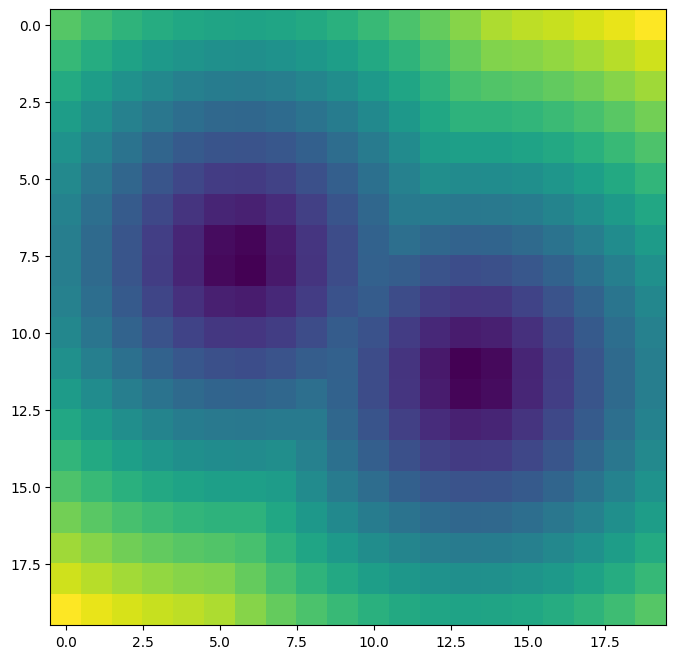

In [ ]:
# Case 1:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7]], 20)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)
plt.show()

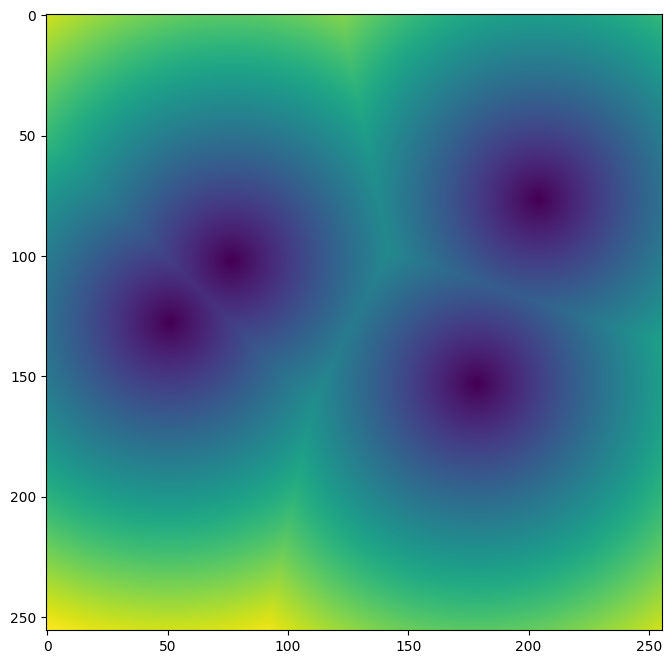

In [ ]:
# Case 2:
distance_to_data = min_dist([[0.4, 0.3], [0.6, 0.7], [0.3, 0.8], [0.5, 0.2]], 256)
plt.figure(figsize=(8, 8))
plt.imshow(distance_to_data)

# Part 3-1b: Batched version

As a next step, improve the `min_dist` function to support batches.
The `points` array is now expected to be a tensor with shape [batch_size, num_points, 3], generated by `create_points`.
`min_dist` should return a batch of maps with shape [batch_size, res, res].
Again, make sure to implement `min_dist` using **no for-loops**.
Demonstrate your function output with `batch_size=3` and `num_points=4`.

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
def create_points(batch_size, num_points):
  coords = np.random.rand(batch_size, num_points, 2)
  coords = torch.tensor(coords, dtype = torch.float32)
  return coords

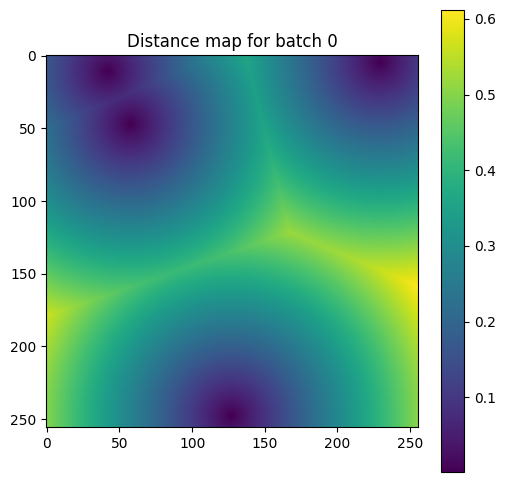

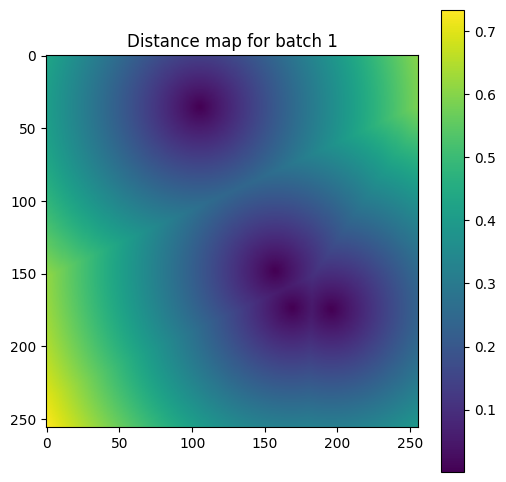

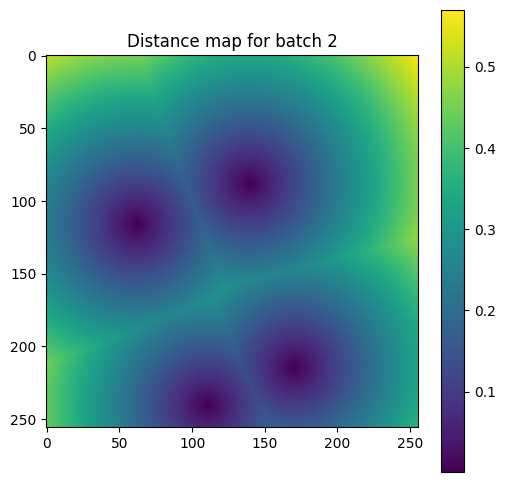

In [ ]:
def min_dist(points, res):
  """Calculates a 3D tensor with the minimum distance from each pixel to data.

  Inputs:
    * points: a numpy array of 2D coordinates and point values, normalized to
              be in the range [0,1]. The expected shape is [B, P, 2].
    * res: the resolution of the output tensor.
  Returns:
    A res x res square tensor with floating point values corresponding to the
    euclidean distance to the closest point in points. The return tensor
    shape is [B, res, res].
  """
  # reading B->batch size(1st dim) , P-> number of point in each batch(2nd dim) & 2 -> 2D cordinates
  B, P, _ = points.shape

  # step 1:  create res* res * 2 shape meshgrid
  x = torch.linspace(0, 1, res)
  y = torch.linspace(0, 1, res)
  x_grid, y_grid = torch.meshgrid(x, y, indexing = "ij")
  # creating a grid of res *res * 2
  grid = torch.stack([x_grid, y_grid], dim = -1)

  ''' step 2 : expand dimension for broadcasting
      .unsqueeze(0) -> add new dimension at beginning of tensor -> 1*res*res*2
      .unsqueeze(-2) -> add at second-to-last operation -> 1*res*res*1*2
  '''
  grid = grid.unsqueeze(0).unsqueeze(-2)
  # points shape -> B*1*1*P*2
  points = points.unsqueeze(1).unsqueeze(1)

  ''' step 3 : euclidean distance to all points
      when "grid - points" performed pytorch automatically brodcast tensor to compatible shape
      -> resulting shape= max(grid, points) -> max((1*res*res*1*2),(B*1*1*P*2)) -> (B*res*res*P*2)
      --> also dim = -1 reduce last dimension -> (B*res*res*P)
  '''
  distances = torch.norm(grid - points, dim = -1)

  ''' step 4 :  findinf the closest distance for each pixels in each batch
      d_minimum shape -> (B*res*res) as P is reduced by dim  = -1
  '''
  d_minimum = torch.min(distances, dim = -1).values

  return d_minimum

# example case
BATCH_SIZE = 3
NUM_POINTS = 4
RESOLUTION = 256
# creating a random batches of points
point = create_points(BATCH_SIZE, NUM_POINTS)
#calculating a distance
distance_to_data = min_dist(point, RESOLUTION)

# plotting data
for i in range(BATCH_SIZE):
  plt.figure(figsize =(6,6))
  plt.title(f"Distance map for batch {i}")
  plt.imshow(distance_to_data[i], cmap = "viridis")
  plt.colorbar()
  plt.show()

# Part 3-2: Scalable version

Assume `res` can be very large (up to 65,536). Running the above function will likely cause the computer's RAM to be filled up, and fail (on a free colab instance, even 16,384 `res` will crash with `batch_size=3` and `num_points=4`).
Extend the above version of `min_dist` to calculate the result tensor at such high resolution without running out of RAM. This function may be less computationally efficient, as long as it can successfully run.

In [ ]:
''' reason for memory constrain
    each 'distance map' shape -> [BATCH_SIZE* res * res]
    memory used by distance tesor = B*res*res*P -> 3* 65,536*65,536*4 -> 51,539,607,552
    each float32 size -> 4 bytes -> total memory usage wii be -> 206GB
  ----------------------------------------------------------------------
  method used in this code:
  1. creating a 512 * 512 blocks instead of 53,536 * 65,536 tensor
  2. calculate distance fro that block only
  3. store minimum distance for that block
  4. move to next block and repeat until entire image
'''

def create_points(batch_size, num_points):
  coords = np.random.rand(batch_size, num_points, 2)
  coords = torch.tensor(coords, dtype = torch.float32)
  return coords

In [ ]:
def min_dist(points, res, block_size = 512):
  B,P,_ = points.shape

  # initialize output tensor -> no memory is allocated
  min_distances = torch.full((B, res, res), float("inf"), dtype = torch.float32)

  # generate 1D linspace for x and y coordinates
  x = torch.linspace(0, 1, res)
  y = torch.linspace(0, 1, res)

  # process image in 512*512 chunk or block_size*block*size
  for i in range(0, res, block_size):
    for j in range(0, res, block_size):
      # creating 512*512*2 subgrid
      grid_x, grid_y = torch.meshgrid(x[i:i+block_size], y[j:j+block_size], indexing="ij")
      grid = torch.stack([grid_x, grid_y], dim = -1)

      # expanding dimension for broadcasting
      grid = grid.unsqueeze(0).unsqueeze(-2)
      expand_points =points.unsqueeze(1).unsqueeze(1)

      distances = torch.norm(grid - expand_points, dim = -1)

      # get minimum distance for each pixel
      min_block_distance = torch.min(distances, dim = -1).values

      # store in the output tensor (block wise)
      min_distances[:, i:i + block_size, j:j + block_size] = min_block_distance

  return min_distances

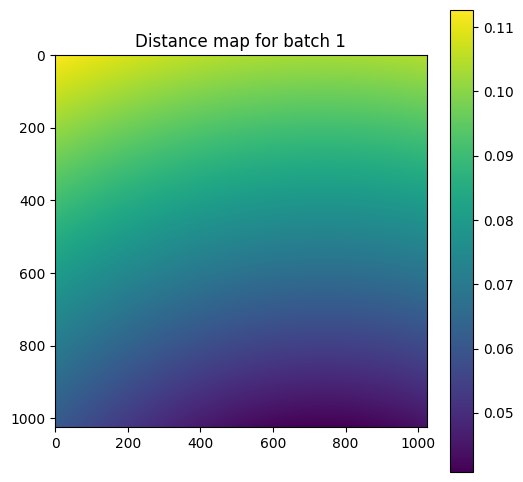

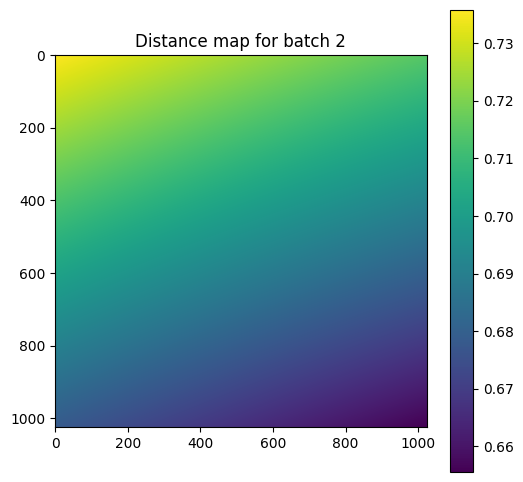

In [ ]:
# checking the output
BATCH_SIZE = 2
NUM_POINTS = 4
RESOLUTION = 16_384   # trail 1
BLOCK_SIZE = 512      # 512 *512
# generate random data first
batched_point = create_points(BATCH_SIZE, NUM_POINTS)

# calculating  distance (per batch )
distance_map = min_dist(batched_point, RESOLUTION, BLOCK_SIZE)

# plotting each batch of image
for i in range(BATCH_SIZE):
  plt.figure(figsize = (6,6))
  plt.title(f"Distance map for batch {i + 1}")
  plt.imshow(distance_map[i][:1024, :1024], cmap = "viridis")
  plt.colorbar()
  plt.show()